# Using Covarience Matrices to Calculate Errors in Custom Bins

### Let's get everything we need to set up. Here we will import the MaNGA map for one sample galaxy. 

In [1]:
#import required modules
import numpy as np
import matplotlib.pyplot as plt

from marvin.tools.maps import Maps

INFO: No release version set. Setting default to MPL-7


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
ex_map = Maps("1-134293")

/homes/sshamsi/.local/lib/python3.5/site-packages/marvin/tools/maps.py:272: MarvinUserWarning: mismatch between file version=DR15 and object release=MPL-7. Setting object release to DR15
  marvin.core.exceptions.MarvinUserWarning)


In [3]:
ha_map = ex_map['emline_gflux_ha_6564']

### This function will loop through the emission map and create the covariance matrix.

In [4]:
def map_covar(emap):
    r, c = emap.shape
    
    if r != c:
        raise ValueError("r != c, the dimestions of emission map aren't equal!")
        
    covar_matrix = np.zeros((r**2, r**2))
    
    for i in range(r):
        for j in range(r):
            
            for k in range(r):
                for h in range(r):
                    if (emap.ivar[i, j] == 0) or (emap.ivar[k, h] == 0):
                        covar_matrix[(i * r) + j, (k * r) + h] = 0
                        continue
                    
                    dist = np.sqrt((i - k)**2 + (j - h)**2)
                    
                    if dist < 6.4:
                        rho = np.exp(-0.5 * (dist / 1.9)**2)
                    else:
                        rho = 0
                        
                    c = rho / np.sqrt(emap.ivar[i, j] * emap.ivar[k, h])
                    
                    covar_matrix[(i * r) + j, (k * r) + h] = c
                    
    return covar_matrix

In [5]:
#let's run the function
covar_map = map_covar(ha_map)

### Here we can use Matplotlib to visualise the matrix. It's hard to see but there is a diagonal going from the top-left to the bottom-right. This is the sign of a typical covariance matrix.

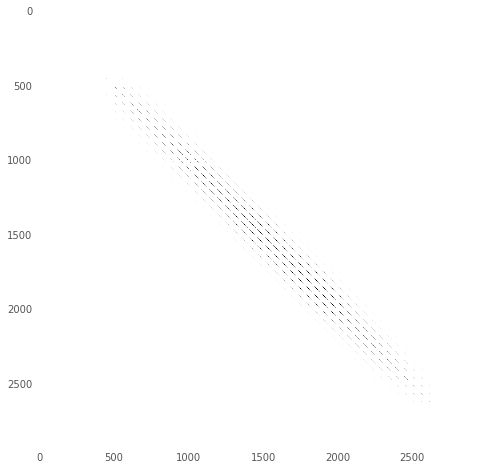

In [27]:
plt.style.use('seaborn-colorblind')

plt.figure(figsize=(8, 8))
plt.imshow(covar_map, vmin=0, vmax=0.003)

In [10]:
covar_map.min()

0.0

### Next, we get our weight matrix. The weight matrix is the object through which we can define our bins. For example, an (1 x N) matrix could serve as our weight matrix W. Each element in W represents a spaxel in our emission map. Each W element could then either be 1 or 0, depending on if we need the spaxel in our bin or not.

### I had originally planned to make a W matrix out of my previous spiral code, but it is a process which will require me to strip down my original code and implement it. Instead, we can pretent that we want a bin in which every other spaxel is included.

In [8]:
W = np.zeros((1, ha_map.size))

for i in range(ha_map.size):
    if i%2 == 0:
        W[0, i] = 1

### We can now perform our linear algebra

In [9]:
from numpy import linalg

In [12]:
C_result = np.dot(np.dot(W, covar_map), W.T)

In [13]:
print(C_result)

[[12.81917496]]


### And that is the fractional error on our bin (13 %).

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd17fb965f8>)

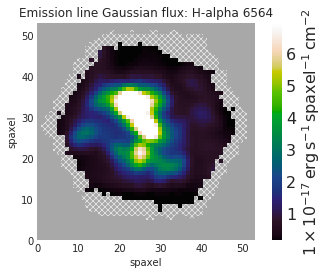

In [14]:
ha_map.plot()

In [16]:
W.shape

(1, 2916)